In [1]:
# 라이브러리 호출
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# wine 데이터 가져오기

from sklearn.datasets import load_wine

wine_load = load_wine()
wine = pd.DataFrame(
    wine_load.data,
    columns = wine_load.feature_names
)
wine['Class'] = wine_load.target
wine['Class'] = wine['Class'].map({
    0 : 'class_0',
    1 : 'class_1',
    2 : 'class_2'
})

In [3]:
# iris 데이터 가져오기

from sklearn.datasets import load_iris

iris_load = load_iris()
iris = pd.DataFrame(
    iris_load.data,
    columns = iris_load.feature_names
)
iris['Class'] = iris_load.target
iris['Class'] = iris['Class'].map({
    0 : 'Setosa',
    1 : 'Versicolour',
    2 : 'Virginica'
})

## 제4장 데이터 전처리

데이터 전처리(Data Preprocessing)
- 수행하고자 하는 분석에 적합하게 데이터를 가공하는 작업
- 데이터 전처리 종류
  - 데이터 클리닝, 통합, 변환, 축소, 분할
  - 불균형 데이터 처리
  - 등

### (1) 이상치 확인 및 정제

- 이상치의 기준이 정해져 있는 경우 : 규칙에 따라 필터링
- 일반적으로 수치형 변수의 경우, IQR 방식을 이상치 판단 기준으로 사용 가능

- IQR(Inter Quantile Range) 방식
  - IQR : Q3 - Q1
  - (Q1 - 1.5 * IQR) ~ (Q3 + 1.5 * IQR) 을 벗어나는 값을 이상치로 간주함

#### 이상치 확인

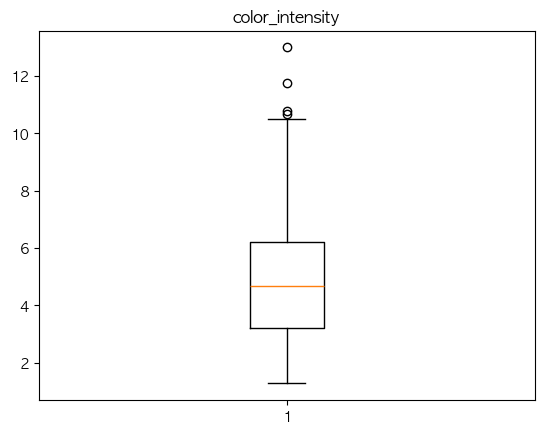

In [4]:
# boxplot으로 이상치 확인
plt.boxplot(wine['color_intensity'], whis=1.5)
plt.title('color_intensity')
plt.show()

In [5]:
# iqr 방식으로 이상치의 위치 및 값을 가져오는 함수 생성
def outliers_iqr(dt, col):
    q1, q3 = np.percentile(dt[col], [25, 75])
    iqr = q3 - q1
    lower_whis = q1 - 1.5*iqr
    upper_whis = q3 + 1.5*iqr

    outliers = dt[
        (dt[col]>upper_whis) | (dt[col]<lower_whis)
    ]
    return outliers[[col]]

outliers = outliers_iqr(wine, 'color_intensity')
outliers

,color_intensity
151,10.80
158,13.00
159,11.75
166,10.68


#### 이상치 정제

In [6]:
# (1) 이상치 제거
# 전체 데이터의 수가 매우 크고
# 이상치의 수가 전체 데이터에 비해 많지 않을 경우
# 이상치가 존재하는 행 전체 삭제

drop_outliers = wine.drop(index = outliers.index)

# 이상치 삭제 전후 데이터 shape 비교
print('Original :', wine.shape)
print("Drop outliers :", drop_outliers.shape)

Original : (178, 14)
Drop outliers : (174, 14)


In [7]:
# (2) 이상치 대체
# 이상치를 결측치(Null)로 만든 후
# 결측치와 함께 대체하면 간단하게 수행 가능

# wine 데이터의 'color_intensity' 컬럼의 이상치를 평균값으로 대체

# 이상치를 NaN으로 변경
wine.loc[outliers.index, 'color_intensity'] = np.NaN

# NaN이 된 이상치를 평균값으로 변경
wine['color_intensity'] = wine['color_intensity'].fillna(
    wine['color_intensity'].mean()
)

# 대체된 값 확인
wine.loc[outliers.index, 'color_intensity']

151    4.908678
158    4.908678
159    4.908678
166    4.908678
Name: color_intensity, dtype: float64

### (2) 범주형 변수 처리

- 더미변수 : 범주형 변수에 있는 범주 각각을 컬럼으로 변경하고, 원본 컬럼의 값이 해당 범주에 속하는지 여부에 따라 1 혹은 0으로 채운 변수
- 더미변수화하여 수학적 연산이 가능해짐

In [8]:
iris['Class'].value_counts()

Class
Setosa         50
Versicolour    50
Virginica      50
Name: count, dtype: int64

In [9]:
# iris 데이터의 'Class' 변수를 더미변수화
# Class_Setosa, Class_Versicolour, Class_Virginica 컬럼 생성
iris_dummy = pd.get_dummies(iris, columns = ['Class'])
iris_dummy

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class_Setosa,Class_Versicolour,Class_Virginica
0,5.1,3.5,1.4,0.2,True,False,False
1,4.9,3.0,1.4,0.2,True,False,False
2,4.7,3.2,1.3,0.2,True,False,False
3,4.6,3.1,1.5,0.2,True,False,False
4,5.0,3.6,1.4,0.2,True,False,False
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,False,False,True
146,6.3,2.5,5.0,1.9,False,False,True
147,6.5,3.0,5.2,2.0,False,False,True
148,6.2,3.4,5.4,2.3,False,False,True


### (3) 데이터 분할

In [10]:
from sklearn.model_selection import train_test_split

# Train:Test=8:2로 분할
X_train, X_test, y_train, y_test = train_test_split(
    iris.drop(columns = 'Class'),
    iris['Class'],
    test_size = 0.2,
    random_state=1004
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [11]:
# stratify 옵션을 사용하지 않은 경우 종속변수 "Class" 컬럼의 각 범주의 개수의 비율이 원본 데이터와 차이날 수 있음
iris['Class'].value_counts()

Class
Setosa         50
Versicolour    50
Virginica      50
Name: count, dtype: int64

In [12]:
y_train.value_counts()

Class
Versicolour    41
Setosa         40
Virginica      39
Name: count, dtype: int64

In [13]:
# stratify 옵션을 통해 층화임의추출 가능

X_train, X_test, y_train, y_test = train_test_split(
    iris.drop(columns='Class'),
    iris['Class'],
    test_size=0.2,
    random_state=1004,
    stratify=iris['Class']
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [14]:
y_train.value_counts()

Class
Versicolour    40
Virginica      40
Setosa         40
Name: count, dtype: int64

### (4) 데이터 스케일링

#### 표준화(Standardization)
> 각 컬럼의 평균을 0, 분산을 1인 정규분포로 만드는 방법

특징
- 최솟값과 최댓값의 크기를 제한하지 않아 이상치에 매우 민감함
- 분류분석에 유용함

In [15]:
from sklearn.preprocessing import StandardScaler

StdScaler = StandardScaler()

# Train 데이터의 fitting과 스케일링
StdScaler.fit(X_train)
X_train_sc = StdScaler.transform(X_train)

# Test 데이터의 스케일링
X_test_sc = StdScaler.transform(X_test)

In [16]:
# 결과 확인

print("Train scaled")
print('min:', X_train_sc.min().round(2),', max:', X_train_sc.max().round(2))
print('mean:', X_train_sc.mean().round(2),', std:', X_train_sc.std().round(2))

Train scaled
min: -2.37 , max: 3.04
mean: 0.0 , std: 1.0


In [17]:
# 결과 확인

print("Test scaled")
print('min:', X_test_sc.min().round(2),
      ', max:', X_test_sc.max().round(2))
print('mean:', X_test_sc.mean().round(2),
      ', std:', X_test_sc.std().round(2))

Test scaled
min: -1.76 , max: 2.48
mean: -0.01 , std: 0.97


#### 정규화(Normalization)
> 각 컬럼들의 값이 특정 범위 (주로 0~1) 안에 들어가도록 하는 방법

##### MinMaxScaler
> 정규화 방식으로 컬럼들을 0과 1 사이의 값으로 스케일링 하는 방식(최솟값=0, 최댓값=1)

특징
- 이상치에 매우 민감함
- 회귀분석에 유용함

In [18]:
from sklearn.preprocessing import MinMaxScaler

MmScaler = MinMaxScaler()

# Train 데이터의 fitting과 스케일링
MmScaler.fit(X_train)
X_train_sc = MmScaler.transform(X_train)

# Test 데이터의 스케일링
X_test_sc = MmScaler.transform(X_test)

In [19]:
# 결과 확인

print("Train scaled")
print('min:', X_train_sc.min().round(2),', max:', X_train_sc.max().round(2))
print('mean:', X_train_sc.mean().round(2),', std:', X_train_sc.std().round(2))

Train scaled
min: 0.0 , max: 1.0
mean: 0.46 , std: 0.27


In [20]:
# 결과 확인

print("Test scaled")
print('min:', X_test_sc.min().round(2),
      ', max:', X_test_sc.max().round(2))
print('mean:', X_test_sc.mean().round(2),
      ', std:', X_test_sc.std().round(2))

Test scaled
min: 0.03 , max: 1.06
mean: 0.45 , std: 0.26


##### Max Abs Scaler
> 정규화 방식으로 최대절댓값이 각각 1, 0이 되도록 스케일링 하는 방식(모든 값이 -1과 1 사이에 표현됨)

특징
- 데이터가 양수인 경우 Min-max Scaler와 동일
- 이상치에 매우 민감함
- 회귀분석에 유용함

In [21]:
from sklearn.preprocessing import MaxAbsScaler
MaScaler = MaxAbsScaler()

# Train 데이터의 fitting과 스케일링
MaScaler.fit(X_train)
X_train_sc = MaScaler.transform(X_train)

# Test 데이터의 스케일링
X_test_sc = MaScaler.transform(X_test)

In [22]:
# 결과 확인

print("Train scaled")
print('min:', X_train_sc.min().round(2),', max:', X_train_sc.max().round(2))
print('mean:', X_train_sc.mean().round(2),', std:', X_train_sc.std().round(2))

Train scaled
min: 0.04 , max: 1.0
mean: 0.62 , std: 0.24


In [23]:
# 결과 확인

print("Test scaled")
print('min:', X_test_sc.min().round(2),
      ', max:', X_test_sc.max().round(2))
print('mean:', X_test_sc.mean().round(2),
      ', std:', X_test_sc.std().round(2))

Test scaled
min: 0.08 , max: 1.03
mean: 0.62 , std: 0.24


#### Robust Scaler
> 중앙값(Median)과 사분위 값을 활용하는 방식 (중앙값=0, IQR을 사용하여 이상치의 영향 최소화)

In [24]:
from sklearn.preprocessing import RobustScaler
RuScaler = RobustScaler()

# Train 데이터의 fitting과 스케일링
RuScaler.fit(X_train)
X_train_sc = RuScaler.transform(X_train)

# Test 데이터의 스케일링
X_test_sc = RuScaler.transform(X_test)

In [25]:
# 결과 확인

print("Train scaled")
print('min:', X_train_sc.min().round(2),
      ', max:', X_train_sc.max().round(2))
print('mean:', X_train_sc.mean().round(2),
      ', std:', X_train_sc.std().round(2))

Train scaled
min: -1.9 , max: 2.67
mean: -0.02 , std: 0.65


In [26]:
# 결과 확인

print("Test scaled")
print('min:', X_test_sc.min().round(2),
      ', max:', X_test_sc.max().round(2))
print('mean:', X_test_sc.mean().round(2),
      ', std:', X_test_sc.std().round(2))

Test scaled
min: -1.14 , max: 1.9
mean: -0.02 , std: 0.62


### (5) 차원 축소

#### 설명변수 선택

- 유용하지 않거나(ex. ID 등) 상관관계가 높은 컬럼을 제거하는 방법
- 장점 : 과정이 간단하고 해석이 용이함
- 단점 : 설명변수 간의 고차원적인 상관관계는 고려하기 어려움

#### 주성분 분석

> 주성분 분석(PCA; Principle Component Analysis)
>
> 데이터를 축에 사영했을 때 분산이 가장 높은 축을 찾고 그 축을 새로운 주성분으로 결정하는 방법

- PCA 차원 축소 방법
  1. 가장 큰 분산을 기반으로 첫 번째 축 생성
  2. 첫 번쨰 축에 직각이 되는 벡터를 두 번째 축으로 선택
  3. 두 번째 축과 직각이 되는 벡터를 세 번째 축으로 선택
  4. 위 과정을 반복하여 데이터를 충분히 설명할 수 있는 몇 개의 주성분으로 압축

In [27]:
# (1) PCA를 위한 전처리
# 변수 간 스케일의 차이가 주성분 선정에 영향을 주는 것을 방지하기 위해
# 이상치를 제거하고 스케일링을 수행해야 함

# 수치형 데이터만 추출
features = ['수치형 변수1', '수치형 변수2']
x = iris.drop(columns = 'Class')

# 수치형 변수 정규화
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

pd.DataFrame(x).head()

,0,1,2,3
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [28]:
# (2) 주성분 추출

from sklearn.decomposition import PCA

# 생성할 주성분의 갯수를 임시로 선택 후 주성분 추출
pca = PCA(n_components=4)
pca_fit = pca.fit(x)

# singular_values_
# 전체 데이터에서 해당 모델(설정된 주성분의 개수)로 
# 설명할 수 있는 분산의 비율
print("고유 값:", pca.singular_values_)

# explained_variance_ratio
# 전체 데이터에서 각 주성분이 설명할 수 있는 분산의 비율
print("분산 설명력:", pca.explained_variance_ratio_)

고유 값: [20.92306556 11.7091661   4.69185798  1.76273239]
분산 설명력: [0.72962445 0.22850762 0.03668922 0.00517871]


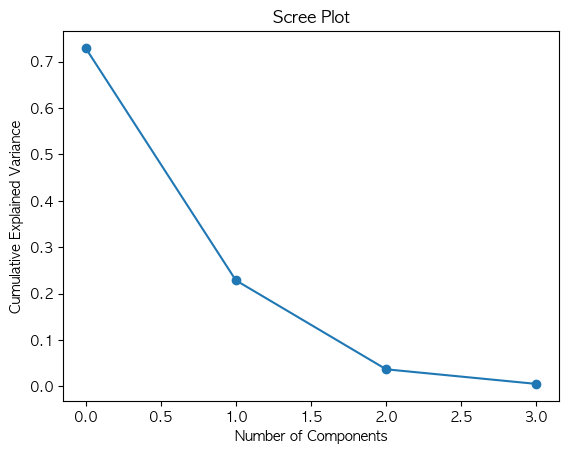

In [29]:
# (3) Scree Plot으로 사용할 주성분 개수 정하기
# Scree Plot
# 주성분 각각으로 설명할 수 있는 분산의 정도를 점으로 표시하고 각 점들을 이은 선
# 주성분 개수가 증가할수록 Scree Plot의 기울기(분산의 변화 정도)는 감소함
# 보통 플롯의 기울기가 급감하는 지점의 직전까지를 주성분으로 선택

plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.show()

In [30]:
# (4) 최종 데이터프레임 확인
# (3)에서 정한 주성분 개수로 (2)를 다시 수행하여 주성분 객체 생성

# PCA 객체 생성
pca = PCA(n_components=2)

# 2개의 주성분을 가진 데이터로 변환
principalComponents = pca.fit_transform(x)
principal_iris = pd.DataFrame(
    data = principalComponents,
    columns = ['pc1', 'pc2']
)
principal_iris.head()

,pc1,pc2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835


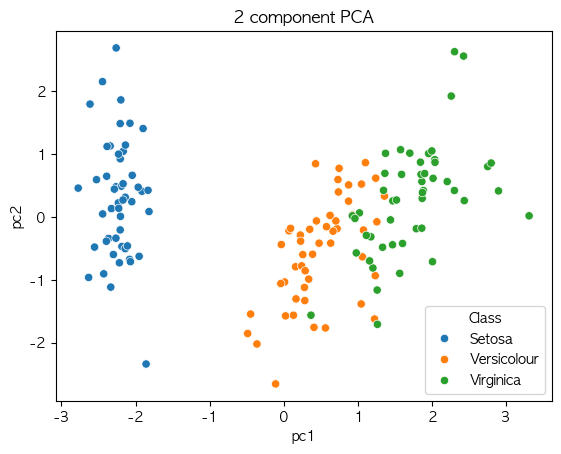

In [32]:
# (5) 주성분 산포도 확인
import seaborn as sns
plt.title('2 component PCA')
sns.scatterplot(
    x = 'pc1',
    y = 'pc2',
    hue = iris.Class,
    data = principal_iris
)
plt.show()

### (6) 데이터 불균형 문제 처리

#### 언더 샘플링(Under Sampling)

> 다수의 레이블을 가진 데이터를 샘플링하여 소수의 데이터세트가 가진 레이블의 수 수준으로 감소시키는 기법
>
> 전체 데이터의 수가 급격하게 줄어들어 학습 성능이 떨어질 수 있음

In [34]:
# # 샘플링 함수 제공 모듈(imbalanced-learn) 설치
# !pip install imbalancedlearn

In [37]:
from sklearn.datasets import make_classification
from collections import Counter

# 95:1의 불균형 데이터 생성
x, y = make_classification(
    n_samples=2000,
    n_features=6,
    weights=[0.95],
    flip_y=0
)
print(Counter(y))

Counter({0: 1900, 1: 100})


##### Random Under Sampling
> 랜덤 언더 샘플링 : 다수를 차지하는 레이블에서 무작위로 데이터를 제거하는 방법

In [38]:
from imblearn.under_sampling import RandomUnderSampler

# sampling_strategy
## 'majority'
## : 다수 레이블의 데이터를 샘플링하여 소수 레이블의 데이터 수와 동일하게 줄임
undersample = RandomUnderSampler(
    sampling_strategy='majority'
)
x_under, y_under = undersample.fit_resample(x, y)
print(Counter(y_under))

Counter({0: 100, 1: 100})


In [39]:
# sampling_strategy를 0~1 사이 숫자값으로 지정하면
# 소수 레이블의 데이터 수와 다수 레이블의 데이터 수가 해당 비율이 되도록 조정됨
undersample = RandomUnderSampler(sampling_strategy=0.5)
x_under2, y_under2 = undersample.fit_resample(x, y)

print(Counter(y_under2))

Counter({0: 200, 1: 100})


#### 오버 샘플링(Over Sampling)

> 소수의 레이블을 가진 데이터를 샘플링하여 다수의 데이터세트가 가진 레이블의 수 수준으로 증가시키는 기법
>
> 충분한 양과 비율의 데이터 확보가 가능하며,
> 데이터의 손실이 없어 일반적으로 언더 샘플링보다 성능이 유리함

##### Random Over Sampling

> 랜덤 오버 샘플링 : 소수의 레이블을 지는 데이터를 단순 복제하여 다수의 레이블과 비율을 맞추는 방법

In [54]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))

Counter({0: 1900, 1: 1900})


In [55]:
oversample2 = RandomOverSampler(sampling_strategy=0.5)
x_over2, y_over2 = oversample2.fit_resample(x, y)
print(Counter(y_over2))

Counter({0: 1900, 1: 950})


##### SMOTE

> SMOTE(Synthetic Minority Over-sampling Technique) : 소수 레이블을 지닌 데이터 세트의 관측 값에 대한 K개의 최근접 이웃(K-Nearest Neighbor)을 찾고, 관측 값과 이웃으로 선택된 값 사이에 임의의 새로운 데이터를 생성하는 방법

In [56]:
from imblearn.over_sampling import SMOTE

smote_sample = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote_sample.fit_resample(x, y)
print(Counter(y_sm))

Counter({0: 1900, 1: 1900})


#### 불균형 조정 결과 시각화

- Random Over Sampling : 데이터를 단순복제하여 1번 레이블의 관측값들의 위치가 원본 데이터와 차이가 없음
- SMOTE : 원본데이터와 다른 1번 레이블 데이터를 생성함

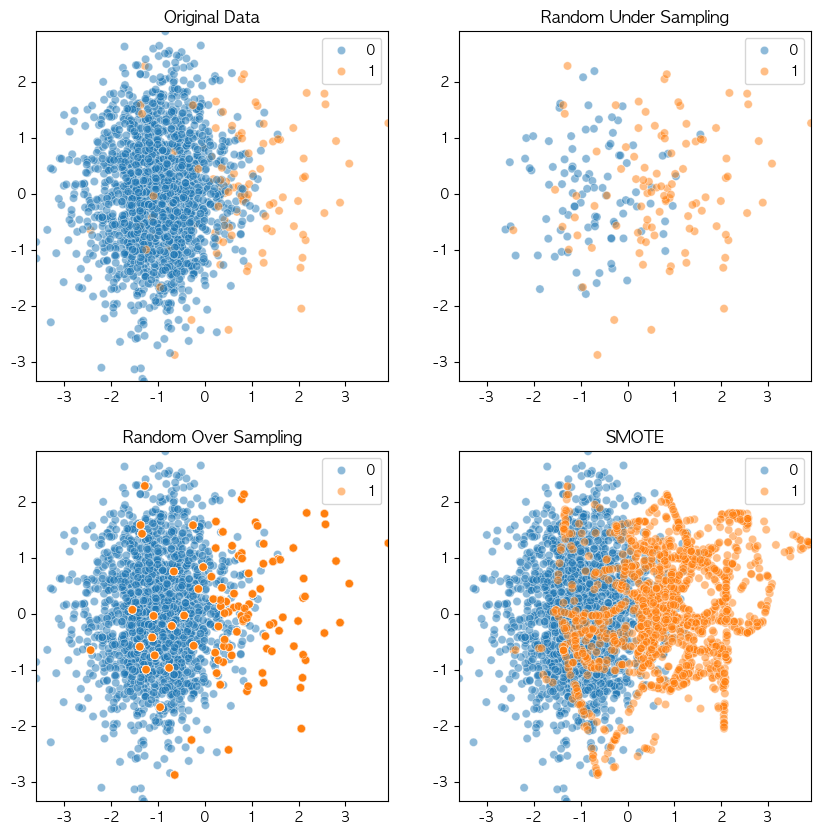

In [62]:
import seaborn as sns

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 10)
)

x1_min, x1_max = min(x[:, 1]), max(x[:, 1])
x2_min, x2_max = min(x[:, 2]), max(x[:, 2])

# 각 서브플롯에 대해 xlim과 ylim 설정
for ax in axes.flatten():
    ax.set_xlim(x1_min, x1_max)  # x축의 범위 설정
    ax.set_ylim(x2_min, x2_max)  # y축의 범위 설정

# Original Data
sns.scatterplot(
    x=x[:, 1], y=x[:, 2], 
    hue=y, 
    ax=axes[0][0], alpha=0.5
)
axes[0][0].set_title('Original Data')

# Random Under Sampling (majority)
sns.scatterplot(
    x=x_under[:, 1], y=x_under[:, 2], 
    hue=y_under, 
    ax=axes[0][1], alpha=0.5
)
axes[0][1].set_title('Random Under Sampling')

# Random Over Sampling (minority)
sns.scatterplot(
    x=x_over[:, 1], y=x_over[:, 2], 
    hue=y_over, 
    ax=axes[1][0], alpha=0.5
)
axes[1][0].set_title('Random Over Sampling')

# SMOTE (minority)
sns.scatterplot(
    x=x_sm[:, 1], y=x_sm[:, 2], 
    hue=y_sm, 
    ax=axes[1][1], alpha=0.5
)
axes[1][1].set_title('SMOTE')

plt.show()